In [15]:
import DataAnalysis as da
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
from uncertainties import ufloat
%matplotlib inline

# Functions

In [16]:
resistance_measurements = []
wavelength_measurements = []

In [17]:
def non_ohmic(V, V_0, a, b, c):
    V = V - V_0
    
    if V < 0:
        return 0
    elif V > c:
        slope = 2*a*c + b
        x_point = c
        y_point = a*c**2 + b*c
        return slope*(V-x_point) + y_point
    return a*V**2 + b*V

def non_ohmic_list(V, V_0, a, b, c):
    return [non_ohmic(volt, V_0, a, b, c) for volt in V]


def stoping_voltage(V_0, a, b, c):
    # y-y_1 = slope(x-x_1)
    # 0-y_1/slope = x - (c+V_0)
    x = c
    y = a*x**2 + b*x
    slope = (2*a*c + b)
    return -y/slope + x + V_0

def stoping_voltage(V_0, a, b, c):
    # y-y_1 = slope(x-x_1)
    # 0-y_1/slope = x - (c+V_0)
    x = c
    y = a*x**2 + b*x
    slope = (2*a*c + b)
    return -y/slope + x + V_0
def slope(a, b, c):
    return 2*a*c + b
def linear_fit(x, a, b, c, V_0):
    V = np.array(x) - V_0
    slope = 2*a*c + b
    resistance_measurements.append(1/slope)
    x_point = c
    y_point = a*c**2 + b*c
    return slope*(V-x_point) + y_point

def freq_func(wavelength): 
    return 3e8/wavelength

def freq_error(wavelength, error):
    return 3e8/wavelength**2*error

In [18]:
def stop_voltage_plot(Voltage, Current, name, estimate_v_0=-649, estimate_c=700):
    assert len(Voltage) == len(Current)
    voltage_err = 1
    current_err = 1
    #combined_err = [da.combine_linear_uncertainties(Voltage, Current, voltage_err, current_err)[0] for _ in range(len(Voltage))]
    combined_err = da.combine_nonlinear_uncertainties(Voltage, Current, voltage_err, current_err, non_ohmic_list, [estimate_v_0, 1, 1, estimate_c])
    print(combined_err)
    print(len(combined_err), len(Voltage))
    assert len(combined_err) == len(Voltage)
    p, cov = opt.curve_fit(non_ohmic_list, Voltage, Current, sigma=combined_err, absolute_sigma=True,p0=[estimate_v_0, 1, 1, estimate_c])
    p_err = np.sqrt(np.diag(cov))/10
    V_0_w_err, a_w_err, b_w_err, c_w_err = [ufloat(val, error) for val, error in zip(p, p_err)]
    V_0, a, b, c = p
    
    volt_sort = np.sort(Voltage)
    volt_spaced = list(range(int(min(Voltage)), 500, 200))
    pred_current_nonlin = non_ohmic_list(volt_sort, V_0, a, b, c)
    pred_current_lin = linear_fit(volt_sort,a, b, c, V_0)
    #c = c if c<estimate_c+500 else estimate_c+500
    
    volt_stop_w_err = -stoping_voltage(V_0_w_err, a_w_err, b_w_err, c_w_err)
    volt_stop = volt_stop_w_err.nominal_value
    volt_stop_err = volt_stop_w_err.std_dev
    if (volt_stop_err > 200):
        volt_stop_err = 200
        volt_stop_w_err = ufloat(volt_stop, volt_stop_err)
    #print(f"The Stopping Voltage is : {volt_stop_w_err}")
    #print(f"The fitted parameters are: {p}")
    print(f"The Stopping Voltage is : {volt_stop_w_err.nominal_value:.0f}±{volt_stop_w_err.std_dev:.0f}")
    fig, ax = plt.subplots(1, 2, figsize=(16,5))
    ax[0].axhline(color="black")    
    ax[0].text(min(Voltage), np.mean(Current)*1.5, f"a = {a:.2e}, b = {b:.2e}")
    ax[0].text(min(Voltage), np.mean(Current)*1.35, f"c = {c:.2e}, v_0 = {V_0:.2e}")
    ax[0].errorbar(Voltage, Current, label="Raw Data", fmt="o", yerr =current_err, xerr=voltage_err,  capsize=2,elinewidth=1, markeredgewidth=2)
    ax[0].plot(volt_sort, pred_current_nonlin, label="Fitted Curve")
    ax[0].plot(volt_sort, pred_current_lin, label="Linear Asymptpte", markeredgewidth=2)
    ax[0].set_ylim((-max(Current)*.02, max(Current)*1.05))
    ax[0].errorbar(-volt_stop, 0, xerr=volt_stop_err,  capsize=2,elinewidth=1, markeredgewidth=2, color='red', zorder=6, label="Stopping Voltage")
    ax[0].set_xlabel("Voltage (mV)")
    ax[0].set_ylabel("Photocurrent (nA)")
    ax[0].set_title("Voltage vs Photocurrent")
    
    ax[1].errorbar(Voltage, np.subtract(non_ohmic_list(Voltage, V_0, a, b, c), Current), label = "Residuals", fmt="o", yerr=current_err, xerr=voltage_err,  capsize=2,elinewidth=1)
    ax[1].axhline(0, label = "Reference Line")
    ax[1].set_xlabel("Voltage (mV)")
    ax[1].set_ylabel("Residual (y_pred - y_act)")
    ax[1].set_title("Residual")    
    ax[0].legend()
    ax[1].legend()
    fig.suptitle(name)
    plt.show()
    return volt_stop_w_err

In [32]:
def stop_voltage_plot(Voltage, Current, name, estimate_v_0=-649, estimate_c=700):
    assert len(Voltage) == len(Current)
    voltage_err = 1
    current_err = 1
    #combined_err = [da.combine_linear_uncertainties(Voltage, Current, voltage_err, current_err)[0] for _ in range(len(Voltage))]
    combined_err = da.combine_nonlinear_uncertainties(Voltage, Current, voltage_err, current_err, non_ohmic_list, [estimate_v_0, 1, 1, estimate_c])
    print(combined_err)
    print(len(combined_err), len(Voltage))
    assert len(combined_err) == len(Voltage)
    p, cov = opt.curve_fit(non_ohmic_list, Voltage, Current, sigma=combined_err, absolute_sigma=True,p0=[estimate_v_0, 1, 1, estimate_c])
    p_err = np.sqrt(np.diag(cov))/10
    V_0_w_err, a_w_err, b_w_err, c_w_err = [ufloat(val, error) for val, error in zip(p, p_err)]
    V_0, a, b, c = p
    
    volt_sort = np.sort(Voltage)
    volt_spaced = list(range(int(min(Voltage)), 500, 200))
    pred_current_nonlin = non_ohmic_list(volt_sort, V_0, a, b, c)
    pred_current_lin = linear_fit(volt_sort,a, b, c, V_0)
    #c = c if c<estimate_c+500 else estimate_c+500
    
    volt_stop_w_err = -stoping_voltage(V_0_w_err, a_w_err, b_w_err, c_w_err)
    volt_stop = volt_stop_w_err.nominal_value
    volt_stop_err = volt_stop_w_err.std_dev
    if (volt_stop_err > 200):
        volt_stop_err = 200
        volt_stop_w_err = ufloat(volt_stop, volt_stop_err)
    #print(f"The Stopping Voltage is : {volt_stop_w_err}")
    #print(f"The fitted parameters are: {p}")
    print(f"The Stopping Voltage is : {volt_stop_w_err.nominal_value:.0f}±{volt_stop_w_err.std_dev:.0f}")
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    ax.axhline(color="black")    
    ax.text(min(Voltage), np.mean(Current)*1.5, f"a = {a:.2e}, b = {b:.2e}")
    ax.text(min(Voltage), np.mean(Current)*1.35, f"c = {c:.2e}, v_0 = {V_0:.2e}")
    ax.errorbar(Voltage, Current, label="Raw Data", fmt="o", yerr =current_err, xerr=voltage_err,  capsize=2,elinewidth=1, markeredgewidth=2)
    ax.plot(volt_sort, pred_current_nonlin, label="Fitted Curve")
    ax.plot(volt_sort, pred_current_lin, label="Linear Asymptpte", markeredgewidth=2)
    ax.set_ylim((-max(Current)*.02, max(Current)*1.05))
    ax.errorbar(-volt_stop, 0, xerr=volt_stop_err,  capsize=2,elinewidth=1, markeredgewidth=2, color='red', zorder=6, label="Stopping Voltage")
    ax.set_xlabel("Voltage (mV)")
    ax.set_ylabel("Photocurrent (nA)")
    ax.set_title(name)
    ax.legend()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    ax.errorbar(Voltage, np.subtract(non_ohmic_list(Voltage, V_0, a, b, c), Current), label = "Residuals", fmt="o", yerr=current_err, xerr=voltage_err,  capsize=2,elinewidth=1)
    ax.axhline(0, label = "Reference Line")
    ax.set_xlabel("Voltage (mV)")
    ax.set_ylabel("Residual (y_pred - y_act)")
    ax.set_title(name)    
    ax.legend()
    plt.show()
    return volt_stop_w_err

In [20]:
def freq_plot(v_stop_w_err, wavelength_w_err, name):
    kin_w_err = [v*1e-3 for v in v_stop_w_err]
    kin, kin_err = da.seperate_uncertainty_array(kin_w_err)
    
    freq_w_err = [freq_func(w/1e9) for w in wavelength_w_err]
    freq, freq_err = da.seperate_uncertainty_array(freq_w_err)
    error = da.combine_linear_uncertainties(kin, freq, kin_err, freq_err)
    
    [m, c], [m_err, c_err], [y_pred, res], [chi_squared] = da.weighted_least_squares_linear(kin, freq, error)
    
    print(f"Calculated cutoff_frequncy {c:.2e}±{c_err:.2e}")
    print(f"Calculated cutoff_wavelength {freq_func(c):.2e}")
    
    print(f"Calculated planks constant: {1/m:.2e}±{m_err/m**2:.2e}")
    print(f"Planks Constant Percent Error: {100*abs(1/m - 4.135667696e-15)/4.135667696e-15:.2f}%")
    fig, ax = plt.subplots(1, 2, figsize=(16,5))
    ax[0].axhline(color="black")    
    #ax[0].errorbar(kin, freq, label="Raw Data", fmt="o", yerr = freq_err, xerr=kin_err,  capsize=2,elinewidth=1, markeredgewidth=2)
    ax[0].scatter(kin, freq, label="Raw Data")
    ax[0].plot(kin, y_pred, label="Fitted Curve")
    ax[0].set_xlabel("Kinetic Energy (eV)")
    ax[0].set_ylabel("Frequency (Hz)")
    ax[0].set_title("Frequency vs Kinetic Energy")
    
    ax[1].errorbar(kin, res, label = "Residuals", fmt="o", yerr = freq_err, xerr=kin_err,  capsize=2,elinewidth=1)
    ax[1].axhline(0, label = "Reference Line")
    ax[1].set_xlabel("Kinetic Energy (eV)")
    ax[1].set_ylabel("Residual (y_pred - y_act)")
    ax[1].set_title("Residual")    
    ax[0].legend()
    ax[1].legend()
    fig.suptitle(name)
    plt.show()
    return ufloat(c, c_err), 1/ufloat(m, m_err)

In [21]:
def open_file_and_return_data(file_name):
    """
    This function will open the Oscilliscope data with the least amount of memory possible to prevent crashing by
    openning and closing the file while only saving the values of the ch1, ch2 and time markers
    These data lists are then returned for data processing and analysis.
    """
    wavelength, voltage, current  = [],[],[]
    
    # opening the CSV file
    with open(file_name, mode ='r') as file:
       # reading the CSV file
        csvFile = csv.reader(file)
        
        headers = next(csvFile)
        assert headers[0] == 'Wavelength (nm)'
        
        wavelength_index = headers.index("Wavelength (nm)")
        voltage_index = headers.index("Voltage (mV)")
        current_index = headers.index("Current (uA)")
        
        # saving the contents of the CSV file
        for lines in csvFile:
            try:
                if (len(wavelength) <= 1):
                    wavelength.append(float(lines[wavelength_index]))
                voltage.append(float(lines[voltage_index]))
                current.append(float(lines[current_index]))    
            except IndexError:
                break
    return wavelength, voltage, current

# Import Data

In [22]:
data1_files = [ "Data/"+file for file in os.listdir("Data") if file.endswith(".csv")]
print(f"Method 1: {data1_files}")

Method 1: ['Data/TRIAL 1 STOPPING VOLTAGE 440.csv', 'Data/TRIAL 1 STOPPING VOLTAGE 525.csv', 'Data/TRIAL 1 STOPPING VOLTAGE 550.csv', 'Data/TRIAL 1 STOPPING VOLTAGE 600.csv', 'Data/TRIAL 1 STOPPING VOLTAGE 475.csv', 'Data/TRIAL 1 STOPPING VOLTAGE 460.csv']


In [23]:
data = [open_file_and_return_data(file) for file in data1_files]

initial_params = [[-649, 700], [-649, 700], [-649, 700], [-649, 700], [-649, 700], [-649, 700]]

In [24]:
print(data)

[([440.0, 10.0], [0.0, -48.0, -94.0, -129.0, -247.0, -303.0, -403.0, -485.0, 54.0, 101.0, 158.0, 210.0, 252.0, 386.0, 450.0, 485.0], [21.0, 16.0, 12.0, 10.0, 9.0, 3.0, 1.0, 0.0, 27.0, 34.0, 40.0, 40.0, 45.0, 50.0, 56.0, 61.0]), ([525.0, 10.0], [0.0, -51.0, -100.0, -136.0, -164.0, -215.0, -255.0, -281.0, -312.0, -411.0, -483.0, 61.0, 101.0, 170.0, 269.0, 310.0, 430.0, 486.0], [65.0, 52.0, 45.0, 32.0, 29.0, 20.0, 16.0, 12.0, 10.0, 5.0, 3.0, 85.0, 96.0, 120.0, 147.0, 158.0, 191.0, 200.0]), ([550.0, 10.0], [0.0, -31.0, -93.0, -120.0, -157.0, -200.0, -252.0, -308.0, -402.0, -485.0, -552.0, -575.0, 51.0, 110.0, 194.0, 248.0, 359.0, 429.0], [40.0, 30.0, 23.0, 21.0, 18.0, 14.0, 12.0, 7.0, 5.0, 3.0, 3.0, 1.0, 43.0, 56.0, 69.0, 78.0, 94.0, 103.0]), ([600.0, 10.0], [0.0, -31.0, -51.0, -80.0, -101.0, -126.0, -140.0, -163.0, -207.0, -219.0, -301.0, -335.0, 37.0, 93.0, 131.0, 207.0, 252.0, 304.0], [36.0, 32.0, 27.0, 23.0, 20.0, 18.0, 14.0, 10.0, 7.0, 5.0, 3.0, 0.0, 47.0, 60.0, 71.0, 91.0, 103.0, 114

16 16
[1.003195714432107, 1.003195714432107, 1.0026174879140186, 1.002192639435621, 1.0010367697768812, 1.0006377401129618, 1.0001650406269245, 1.0000071341132386, 1.003195714432107, 1.003195714432107, 1.003195714432107, 1.003195714432107, 1.003195714432107, 1.003195714432107, 1.003195714432107, 1.003195714432107]
16 16
The Stopping Voltage is : 279±200


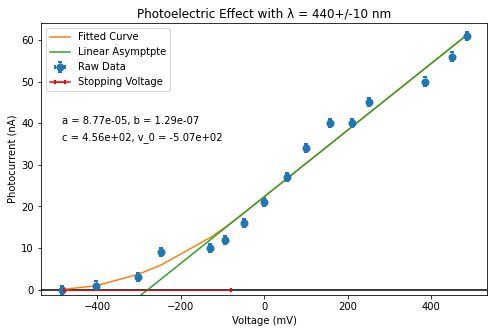

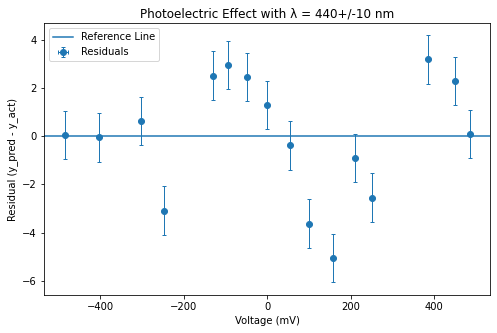

18 18
[1.038206860861467, 1.0307136350060844, 1.024253318624714, 1.0199766807652844, 1.0169291633856947, 1.0120127320543293, 1.0087363138846228, 1.006882549025176, 1.0049583729296236, 1.0009153495561027, 1.0000009905835177, 1.039452829240523, 1.039452829240523, 1.039452829240523, 1.039452829240523, 1.039452829240523, 1.039452829240523, 1.039452829240523]
18 18
The Stopping Voltage is : 239±141


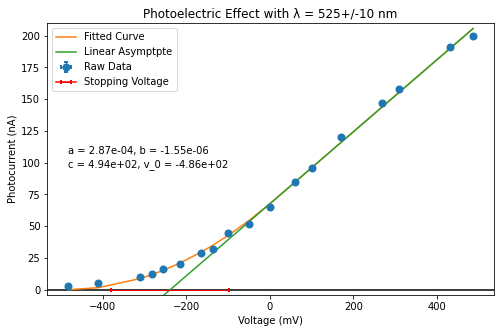

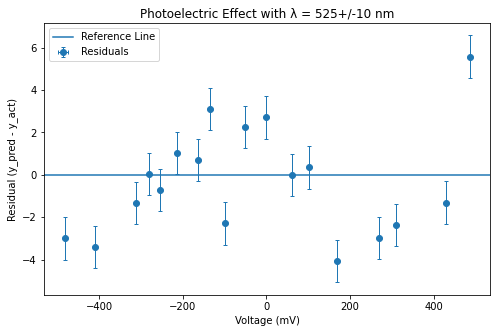

18 18
[1.0098814964573222, 1.0087640912859024, 1.0067281062229751, 1.005924653956783, 1.0049059118541124, 1.0038418513566625, 1.0027277930112934, 1.0017401639238401, 1.0005785851166469, 1.0000713935170367, 1.0, 1.0, 1.011863277581547, 1.0125292035184095, 1.0125292035184095, 1.0125292035184095, 1.0125292035184095, 1.0125292035184095]
18 18
The Stopping Voltage is : 231±200


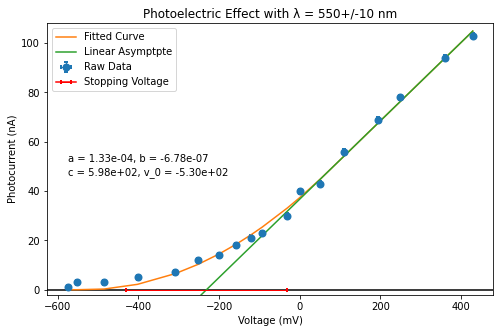

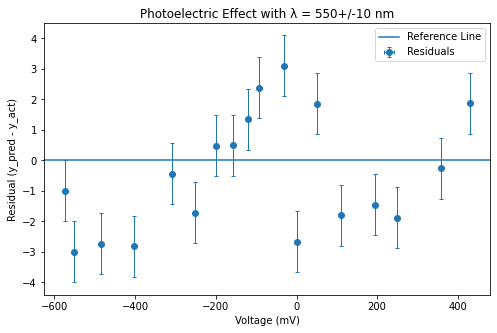

18 18
[1.0224404063430605, 1.0187508584228464, 1.0165416409918722, 1.0135787735316608, 1.0116122118565376, 1.009468442837406, 1.0083621242959286, 1.0066921256123966, 1.0040112808503863, 1.003397864347781, 1.000565395751278, 1.000089335419493, 1.0272618404510154, 1.0334675093665975, 1.0334675093665975, 1.0334675093665975, 1.0334675093665975, 1.0334675093665975]
18 18
The Stopping Voltage is : 138±200


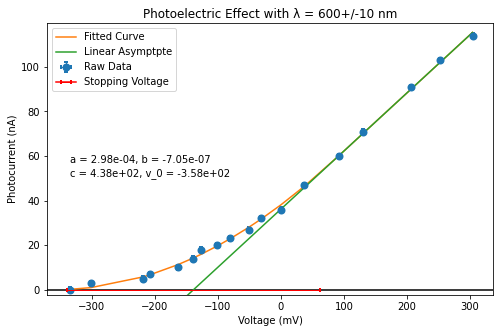

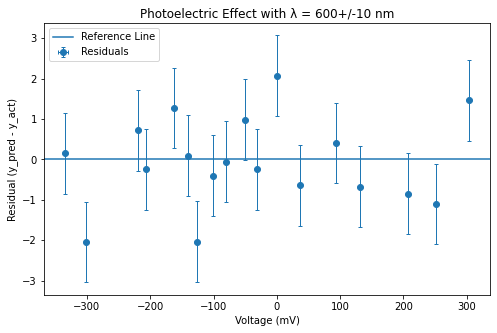

18 18
[1.0488735686409085, 1.037773952143784, 1.030699140773437, 1.0230557737368364, 1.0164735041827089, 1.0109730581863674, 1.0068003336456544, 1.0036137894749073, 1.0012854269393945, 1.00013361665784, 1.0, 1.0, 1.0595316951085245, 1.0704361060414564, 1.07051507704851, 1.07051507704851, 1.07051507704851, 1.07051507704851]
18 18
The Stopping Voltage is : 189±200


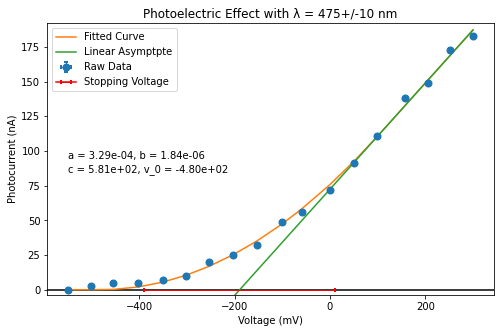

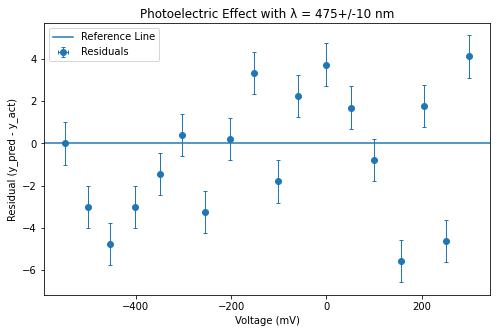

18 18
[1.0106134155044777, 1.0096939217867664, 1.009148492751441, 1.0078843453269335, 1.0070635878724614, 1.0064560864823542, 1.005477640036061, 1.0045551285120244, 1.0036528605632367, 1.0025204924826219, 1.002080639367908, 1.001213732063716, 1.0002649650489694, 1.0000002896579858, 1.0133000422031666, 1.0133000422031666, 1.0133000422031666, 1.0133000422031666]
18 18
The Stopping Voltage is : 257±200


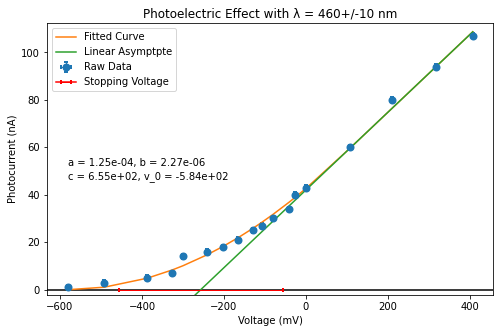

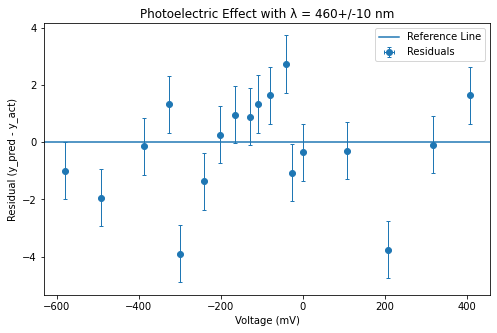

In [33]:
wavelength_w_err = [ufloat(data[i][0][0],data[i][0][1]) for i in range(len(data))]
stop_volt_w_err = [stop_voltage_plot(data[i][1], data[i][2], f"Photoelectric Effect with λ = {wavelength_w_err[i]} nm",
                               initial_params[i][0], initial_params[i][1]) for i in range(len(data))]

m = 9.4e+14±3.6e+31, c = 3.7e+14±7.6e+30, Χ² = 5.2e-34
Equation: y = (9.4e+14±3.6e+31)*x + (3.7e+14±7.6e+30)
Calculated cutoff_frequncy 3.75e+14±7.61e+30
Calculated cutoff_wavelength 8.01e-07
Calculated planks constant: 1.06e-15±4.03e+01
Planks Constant Percent Error: 74.38%


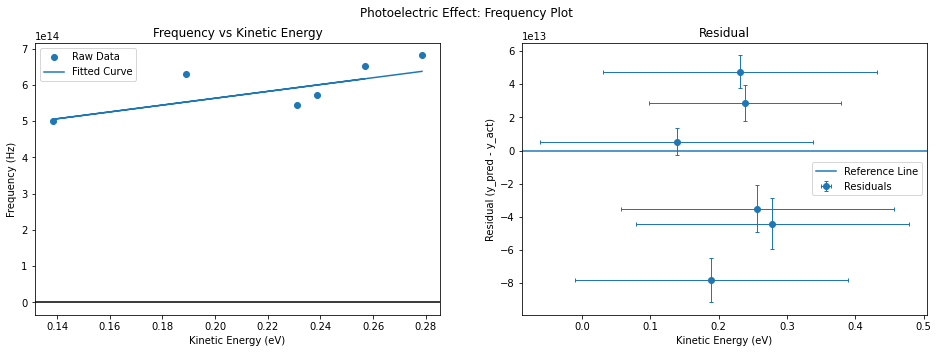

In [12]:
[cut_freq, cut_freq_err] = freq_plot(stop_volt_w_err, wavelength_w_err, "Photoelectric Effect: Frequency Plot")

In [13]:
np.mean(resistance_measurements[1:])

4.475262983992675

In [14]:
resistance_measurements

[12.498037142823515,
 3.524635445691348,
 6.29582635695888,
 3.832372446124839,
 2.613938931544907,
 6.109541739643398]